In [ ]:
# %% Imports & global setup ---------------------------------------------------
import json, warnings
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.decoding import (
    Scaler, Vectorizer, LinearModel, SlidingEstimator, cross_val_multiscore, get_coef
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold

from pyddeeg import EEG_CHANNELS, RQA_METRICS

# ---------- Dataset parameters ---------------------------------------------
DATASET_ROOT = Path("/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset")
WINDOW       = "window_200"   # 200‑ms window length
DIRECTION    = "up"

meta = np.load(DATASET_ROOT / WINDOW / "metadata.npz")
centres_ms = meta["centers"].astype(int)   # e.g. [100, 200, …] length 679
STRIDE_MS  = int(meta["stride"])           # 100 ms
WINDOW_MS  = int(WINDOW.split("_")[-1])    # 200 ms
TOTAL_MS   = centres_ms[-1] + WINDOW_MS//2  # expected 68 000 ms
SFREQ      = 1000 / STRIDE_MS

routes = json.loads((DATASET_ROOT / "dataset_index.json").read_text())[WINDOW][DIRECTION]

# CV splitter ---------------------------------------------------------------
try:
    CV = StratifiedGroupKFold(n_splits=5)
    CV_NAME = "StratifiedGroupKFold"
except ImportError:
    CV = GroupKFold(n_splits=5)
    CV_NAME = "GroupKFold"
    
from pyddeeg.classification.dataloaders import EEGDataset
from pyddeeg.classification.engine import trainer

dataset = EEGDataset.load(dataset_root=DATASET_ROOT, window=WINDOW, direction=DIRECTION, random_state=42)
elec="T7"
results = trainer.compute_auc_per_electrode(elec=elec, 
                                  dataset=dataset, 
                                  model=LinearModel(LogisticRegression(max_iter=1000)))
np.savez(DATASET_ROOT / WINDOW / f"results_{DIRECTION}_{elec}.npz",
         results=results, 
         dataset=dataset)

In [1]:
import numpy as np
import warnings
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from pyddeeg.classification.dataloaders import EEGDataset
from pyddeeg.classification.engine.trainer import classification_per_electrode, permutation_test_decision_scores
from mne.decoding import LinearModel
# ------------------ user parameters (EDIT THESE) ------------------ #
DATASET_ROOT = Path("/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/dataset")
WINDOW       = "window_200"   
DIRECTION    = "up"                      
ELECTRODE    = "T7"
SEED = 42
# ------------------------------------------------------------------ #

dataset = EEGDataset.load(DATASET_ROOT, WINDOW, DIRECTION, random_state=SEED)
print("✅ Loaded real dataset")

# ------------------ model definition ------------------ #
model = LinearModel(LogisticRegression(max_iter=1000,
                           class_weight='balanced',
                           solver='liblinear',
                           random_state=SEED))

# ------------------ run classification ------------------ #
results = classification_per_electrode(ELECTRODE, dataset, model)

# ------------------ permutation test ------------------ #
stats = permutation_test_decision_scores(results['decision_scores'],
                                         results['labels'],
                                         n_permutations=1000,
                                         tail=1,
                                         threshold=dict(start=0.0, step=0.2),
                                         seed=SEED)


print("\n===== SUMMARY =====")
print(f"Decision‑score matrix shape : {results['decision_scores'].shape}")
print(f"Fold‑AUC tensor shape       : {results['fold_auc'].shape}")
print(f"Number of clusters (p<0.05) : {(stats['p_values'])}")


✅ Loaded real dataset
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated


2025-04-19 13:25:36,535 - pyddeeg.classification - INFO - Epochs shape: (49, 15, 679)
2025-04-19 13:25:36,536 - pyddeeg.classification - INFO - == Model Configurations ==
2025-04-19 13:25:36,538 - pyddeeg.classification - INFO - LinearModel configuration: 
{'model__C': 1.0, 'model__class_weight': 'balanced', 'model__dual': False, 'model__fit_intercept': True, 'model__intercept_scaling': 1, 'model__l1_ratio': None, 'model__max_iter': 1000, 'model__multi_class': 'deprecated', 'model__n_jobs': None, 'model__penalty': 'l2', 'model__random_state': 42, 'model__solver': 'liblinear', 'model__tol': 0.0001, 'model__verbose': 0, 'model__warm_start': False, 'model': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42,
                   solver='liblinear')}
2025-04-19 13:25:36,541 - pyddeeg.classification - INFO - SlidingEstimator configuration: <SlidingEstimator(base_estimator=Pipeline(steps=[('scaler', Scaler(info=<Info | 8 non-empty values
 bads: []
 ch_names: T7_RR, T7_D

stat_fun(H1): min=5.3582627287577145e-06 max=17.10248945326257
Running initial clustering …
Using 86 thresholds from 0.00 to 17.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 679 clusters


100%|██████████| Permuting : 999/999 [00:10<00:00,   94.11it/s]



===== SUMMARY =====
Decision‑score matrix shape : (49, 679)
Fold‑AUC tensor shape       : (5, 2, 679)
Number of clusters (p<0.05) : [1.    1.    1.    1.    1.    1.    1.    0.991 0.663 1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    0.581 1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    0.853
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    0.322 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.   

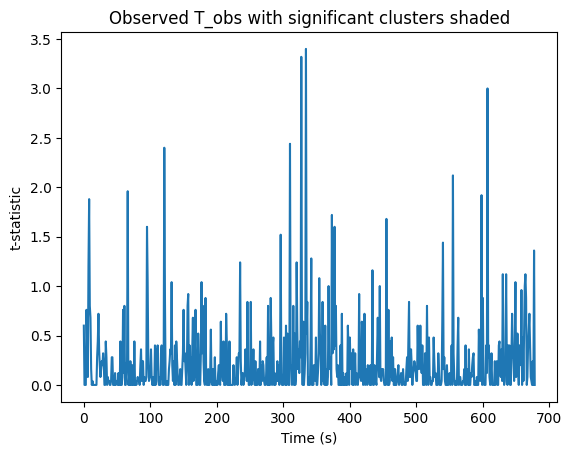

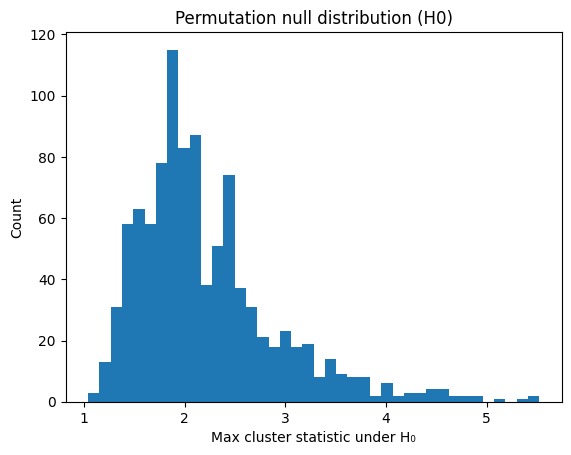

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------
# Demo / utility code to visualise MNE permutation‑test outputs
# ------------------------------------------------------------------

T_obs = stats["T_obs"]
clusters = stats["clusters"]
p_values = stats["p_values"]
H0 = stats["H0"]

times = np.arange(len(T_obs)) / 1

# --------------------------------------------------------------
# 1. Observed cluster statistic across time
# --------------------------------------------------------------
plt.figure()
plt.plot(times, T_obs)
for cl_mask, p in zip(clusters, p_values):
    if p < 0.01:
        plt.axvspan(times[cl_mask][0],
                    times[cl_mask][-1],
                    alpha=0.3)
plt.xlabel("Time (s)")
plt.ylabel("t‑statistic")
plt.title("Observed T_obs with significant clusters shaded")
plt.show()

# --------------------------------------------------------------
# 2. Null distribution of the maximum cluster statistic
# --------------------------------------------------------------
plt.figure()
plt.hist(H0, bins=40)
plt.xlabel("Max cluster statistic under H₀")
plt.ylabel("Count")
plt.title("Permutation null distribution (H0)")
plt.show()


# --------------------------------------------------------------
# 3. Cluster summary tableS
# --------------------------------------------------------------
summary = []
for idx, (cl_mask, p) in enumerate(zip(clusters, p_values)):
    summary.append(
        {
            "cluster": idx,
            "start_time (s)": times[cl_mask][0],
            "end_time (s)": times[cl_mask][-1],
            "duration (s)": times[cl_mask][-1] - times[cl_mask][0],
            "p_value": p,
            "peak_T": float(T_obs[cl_mask].max()),
        }
    )
df = pd.DataFrame(summary)



NameError: name 'plt' is not defined

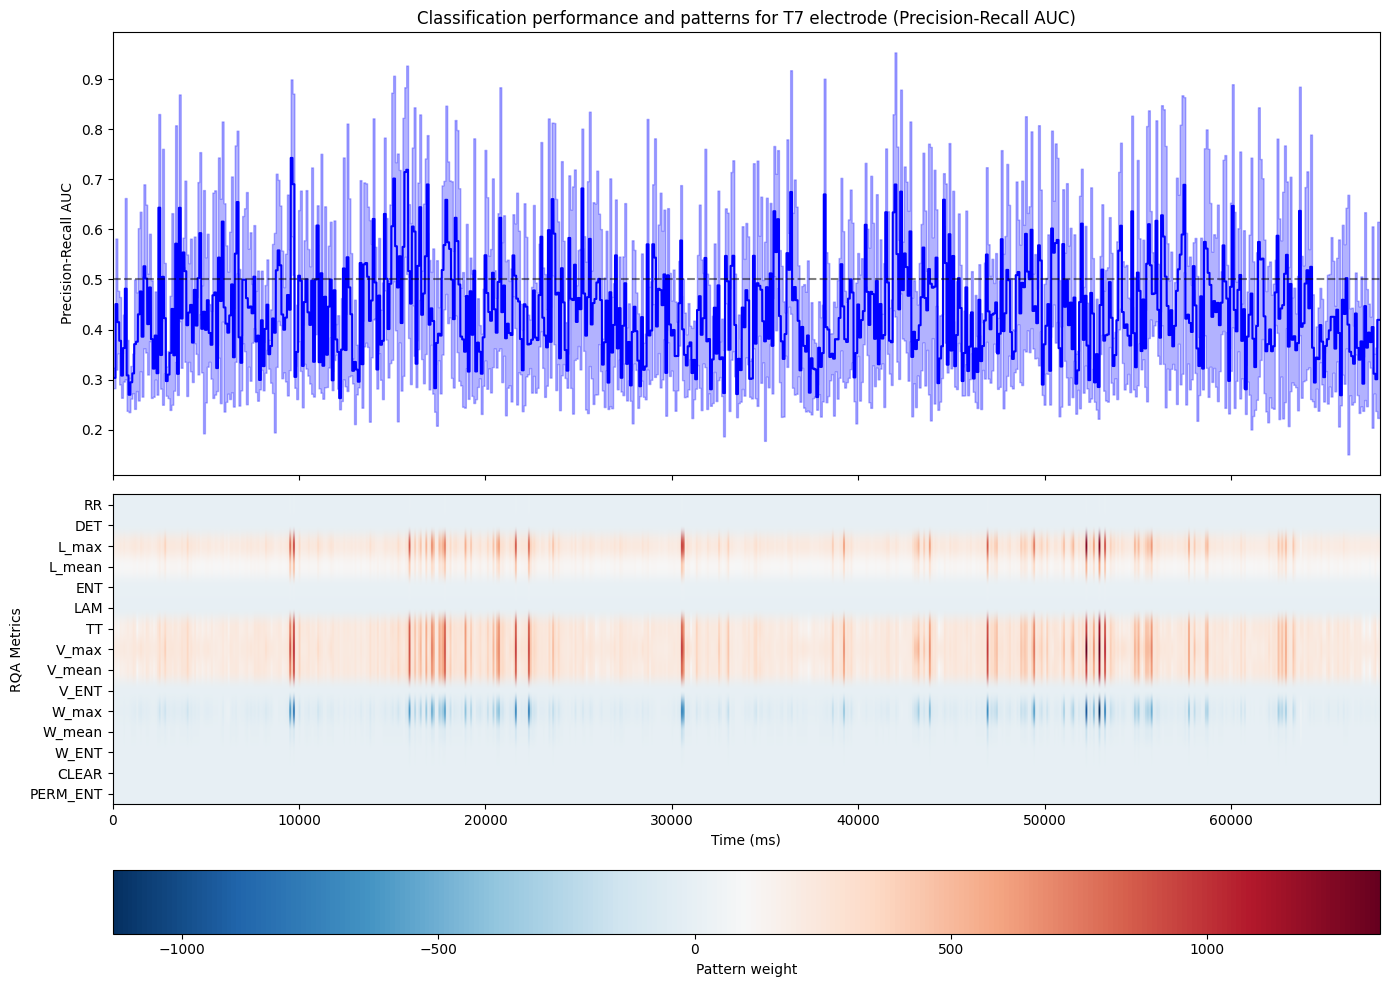

In [3]:
from pyddeeg.classification.utils.basic_visualizations import plot_classification_results

# Basic usage with default styling
fig, axes = plot_classification_results(results, "T7", dataset, metric="pr")

plt.show()